<a href="https://colab.research.google.com/github/denizgulal/Basic_Style_Transfer/blob/main/Basic_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [41]:
network = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [42]:
network.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Content Image

(-0.5, 597.5, 447.5, -0.5)

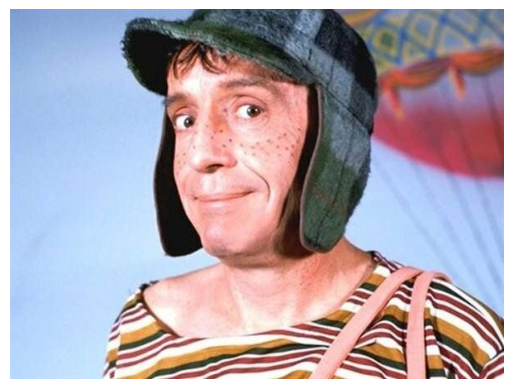

In [44]:
content_image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Computer Vision Masterclass/Images/chaves.jpeg')
plt.imshow(content_image);
plt.axis('off')

In [45]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)

In [46]:
content_image = content_image / 255

In [47]:
content_image = content_image[tf.newaxis, :]
content_image.shape

(1, 448, 598, 3)

Style Images

(1, 560, 600, 3)

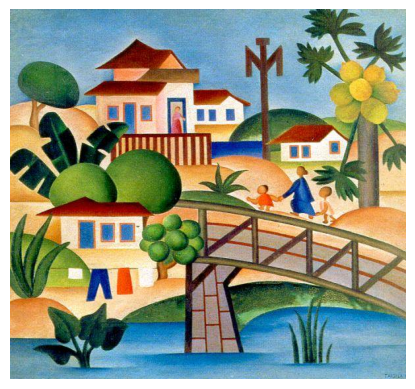

In [50]:
style_image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Computer Vision Masterclass/Images/tarsila_amaral.jpg')
plt.imshow(style_image);
plt.axis('off')

style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255
style_image = style_image[tf.newaxis, :]
style_image.shape

Construct Neural Network

In [51]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [52]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  network = tf.keras.Model(inputs = [vgg.input], outputs = outputs)

  return network

In [53]:
style_extractor = vgg_layers(style_layers)
style_extractor.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [54]:
style_outputs = style_extractor(style_image)

def gram_matrix(layer_activation):
  result = tf.linalg.einsum('bijc,bijd->bcd', layer_activation, layer_activation)
  input_shape = tf.shape(layer_activation)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

  return result / num_locations

In [55]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super().__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs * 255.0
    # 0 - 1
    # -127.50 - 127.50
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs = outputs[:self.num_style_layers]
    content_outputs = outputs[self.num_style_layers:]

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [56]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(content_image)
results

{'content': {'block4_conv2': <tf.Tensor: shape=(1, 56, 74, 512), dtype=float32, numpy=
  array([[[[  17.335257,    0.      ,    0.      , ...,  574.69464 ,
               0.      ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,  291.73862 ,
             132.49077 ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,  333.45657 ,
             117.71992 ,    0.      ],
           ...,
           [ 692.7539  ,    0.      ,    0.      , ..., 1512.0807  ,
              10.164075,  321.67056 ],
           [ 139.49515 ,    0.      ,    0.      , ..., 1108.5737  ,
             102.29349 ,  179.42451 ],
           [ 152.06622 ,    0.      ,    0.      , ...,  471.31982 ,
             179.42244 ,  671.04755 ]],
  
          [[   0.      ,    0.      ,    0.      , ...,  548.79645 ,
               0.      ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,   43.473793,
               0.      ,    0.      ],
           [   0.      ,    0

In [57]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [58]:
new_image = tf.Variable(content_image)
new_image_1 = tf.Variable(content_image)
content_weight = 1
style_weight = 100
optimizer = tf.optimizers.Adam(learning_rate=0.02)

Training

In [59]:
expected_output = np.array([10000, 15000])
predictions = np.array([8000, 15900])

np.sum(abs(expected_output - predictions)) / 2

1450.0

In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mean_absolute_error(expected_output, predictions)
mean_squared_error(expected_output, predictions)

2405000.0

Epoch 600 | content loss: 620219.3125 | style loss: 142700128.0 | total loss 2854622720.0


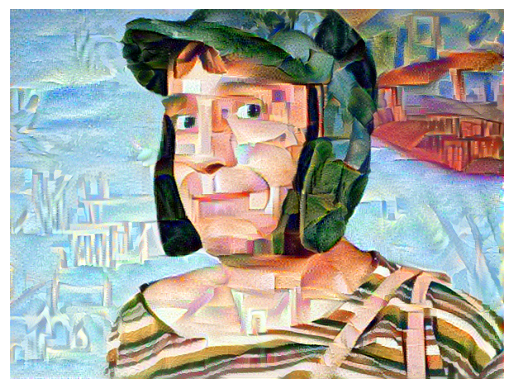

Epoch 1200 | content loss: 634176.3125 | style loss: 640395392.0 | total loss 12808541184.0


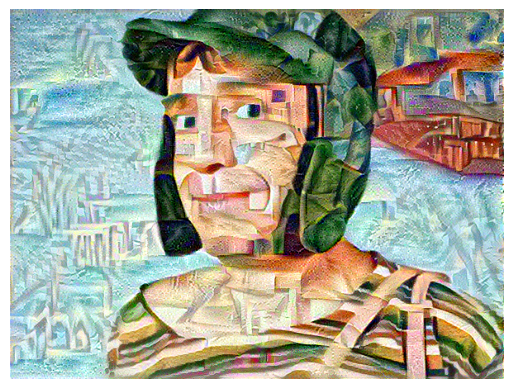

Epoch 1800 | content loss: 677591.1875 | style loss: 76843032.0 | total loss 1537538304.0


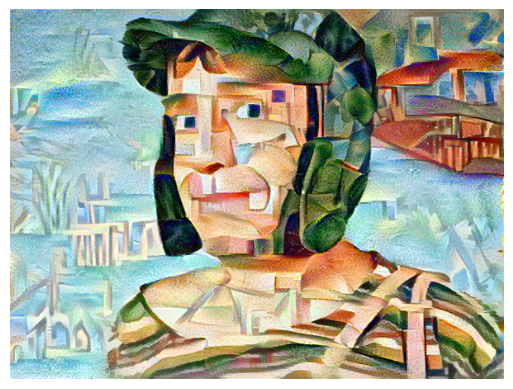

Epoch 2400 | content loss: 687266.5 | style loss: 87871296.0 | total loss 1758113152.0


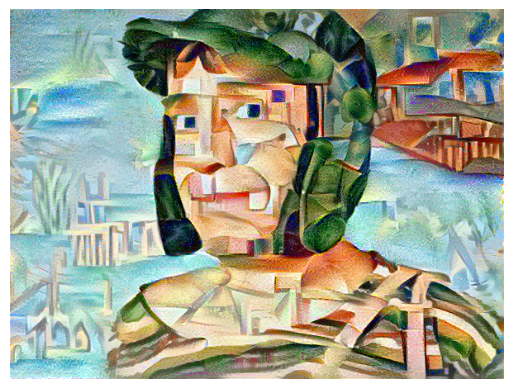

Epoch 3000 | content loss: 705273.0625 | style loss: 73111208.0 | total loss 1462929408.0


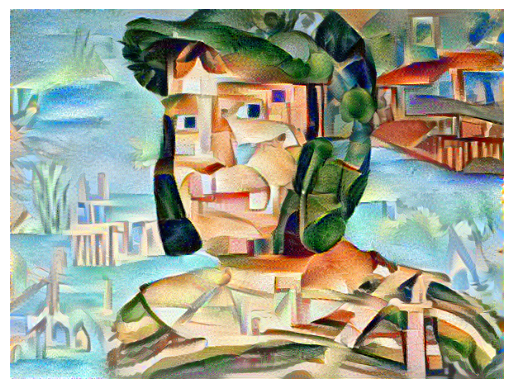

In [61]:
epochs = 3000
print_every = 600

for epoch in range(epochs):
  with tf.GradientTape() as tape:
    outputs = extractor(new_image)

    content_outputs = outputs['content']
    style_outputs = outputs['style']

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])

    total_loss = content_loss * content_weight / num_content_layers + style_loss * style_weight / num_style_layers

  gradient = tape.gradient(total_loss, new_image)
  optimizer.apply_gradients([(gradient, new_image)])

  new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

  if (epoch + 1) % print_every == 0:
    print('Epoch {} | content loss: {} | style loss: {} | total loss {}'.format(epoch + 1, content_loss, style_loss, total_loss))
    plt.imshow(tf.squeeze(new_image, axis = 0))
    plt.axis('off')
    plt.show()


Visualization

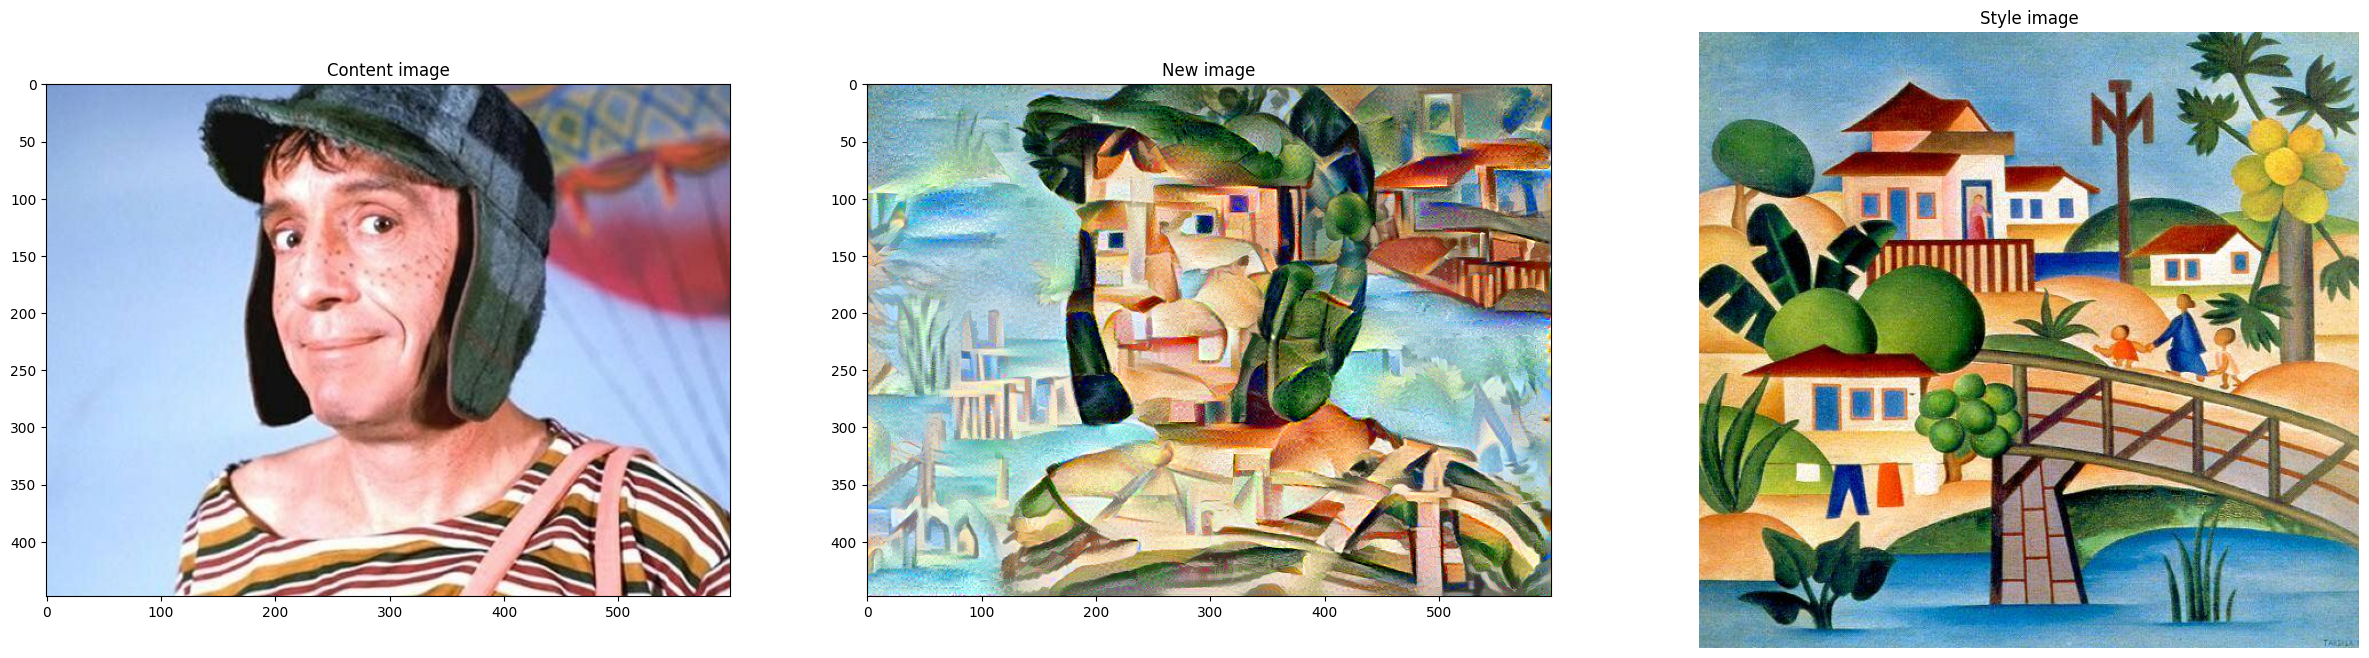

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,8))
ax1.imshow(tf.squeeze(content_image, axis = 0))

ax1.set_title('Content image')

ax2.imshow(tf.squeeze(new_image, axis = 0))
ax2.set_title('New image')

ax3.imshow(tf.squeeze(style_image, axis = 0))
ax3.set_title('Style image')
plt.axis('off');